In [1]:
#Detail of the analysis process see http://localhost:3435/notebooks/task/pore_c/tools/jp_note/statistics/cooltools.ipynb

In [2]:
#@Author: Zhuowen Li
#@LastEdit: 2021/8/8 下午10:50:44
#@Version: 
#@Description: explore .cool after cooler balance

import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.font_manager as font_manager
import seaborn as sns

import numpy as np
import pandas as pd
import bioframe
import cooler
import cooltools 
import cooltools.expected
import matplotlib as mpl
from cycler import cycler
#for more
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#2BB7B3','#3C8C6F','#385D8A','#632523','#C00000','#ED6D00','#FFC000'])
#for three
#

In [3]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ['/public/home/mowp/test/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
def distance_order(args_list):
    tag,mcool,chrom_bed,cen_bed,resolution = args_list
    chrom_bed_table = pd.read_table(chrom_bed,header=None,names=['chrom','start','end'],converters={'chrom':str,'start':int,'end':int})
    #tair10_centromere_location
    cen_bed_table = pd.read_table(cen_bed,header=None,names=['chrom','start','end'],converters={'chrom':str,'start':int,'end':int})
    cen_start = cen_bed_table.loc[:,('chrom','start')].rename(columns={'start':'cut'})
    cen_end = cen_bed_table.loc[:,('chrom','end')].rename(columns={'end':'cut'})

    #P(S) would be seperately calculate for individual chromosomal arms
    cen_cut = pd.concat([cen_start,cen_end],axis=0)

    chrom_arms = bioframe.split(chrom_bed_table, points = cen_cut ,cols_points=['chrom','cut'])
    chrom_arms_retain = chrom_arms.drop(labels=list(range(1,len(chrom_bed_table)*3,3))) 

    clr_read = f'{mcool}::/resolutions/{resolution}'
    clr = cooler.Cooler(clr_read)
    
    #only contain the chromosome that contained in cool matrix
    chrom_arms_retain = chrom_arms_retain.set_index("chrom").loc[clr.chromnames].reset_index()
    
    
    ##balance
    # cvd == contacts-vs-distance
    # balanced 在.cool文件中，balance其实是给每个bin一个权重，所以矩阵每个值balance后是需要×对应的两个bin的weight的
    cvd = cooltools.expected.diagsum(
        clr=clr,
        regions=chrom_arms_retain ,
        transforms={'balanced':lambda p: p['count']*p['weight1']*p['weight2']}
    )
    
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)

    # The resulting table contains P(s) curves for each individual region.
    # Aggregating these curves into a single genome-wide curve is involving too,
    # so we created a separate function for this too.
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )

    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * clr.binsize
    lb_cvd_agg['nor_balanced.avg'] = lb_cvd_agg['balanced.avg']/lb_cvd_agg['balanced.avg'].max()
    
    lb_dict = {}
    lb_dict[tag] = lb_cvd_agg
    return lb_dict

In [5]:
#font setting
def distance_order_draw(draw_dict,draw_ycolumn,xlog,ylog):
    fig, ax = plt.subplots(1, figsize=(3, 3))
    sns.despine(ax=ax)
    for key,value in draw_dict.items():
        ax.plot(
            value['s_bp'],
            value[draw_ycolumn],label = key
        )
        if xlog == True:
            ax.set_xscale('log')
        if ylog == True:
            ax.set_yscale('log')
        ax.set_xlabel('Genomic distance (bp)')
        ax.set_ylabel('Normalized contact frequency')
        ax.tick_params(axis="x")
        ax.tick_params(axis="y")
        ax.set_xticks([1e3, 1e5, 1e7])
    plt.legend()

In [6]:
from concurrent import futures
def distance_order_thread(func,iter_object,max_workers):
    workers = min(max_workers,len(iter_object))
    with futures.ThreadPoolExecutor(workers) as excutors:
        res = excutors.map(func,iter_object)
    return list(res)

In [7]:
from concurrent import futures
def distance_order_process(func,iter_object):
    with futures.ProcessPoolExecutor() as excutors:
        res = excutors.map(func,iter_object)
    return list(res)

In [8]:
#hicVSporec
def mcool_draw(mcool_file,workers,method,outpath):
    mcool_array = pd.read_table(mcool_file).values
    if method == 'thread':
        dis_or_list= distance_order_thread(distance_order,mcool_array,workers)
    if method == 'process':
        dis_or_list= distance_order_process(distance_order,mcool_array)
    
    dis_or_dict = {}
    for i in dis_or_list:
        dis_or_dict.update(i)
    
    distance_order_draw(dis_or_dict,'nor_balanced.avg',xlog=True,ylog=False)
    plt.savefig(outpath,format = 'png',dpi=300,bbox_inches = 'tight')

In [9]:
import matplotlib as mpl
from cycler import cycler

In [10]:
#hicVSdivideorder
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#2BB7B3','#3C8C6F','#385D8A','#632523','#C00000','#ED6D00','#FFC000'])
mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/mcool_table_hicVSdivideorder_new.csv'
out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/Distance_hicVSdivideorder_new.png'

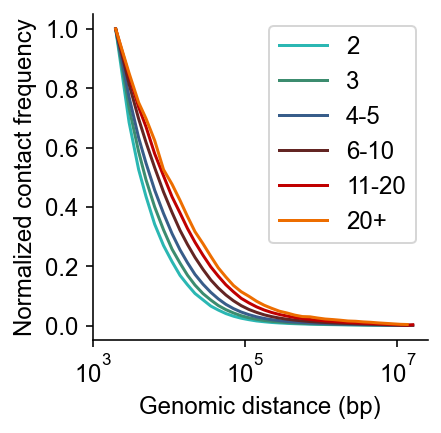

In [18]:
mcool_draw(mcool_hicVSdivideorder, 16,'process', out_hicVSdivideorder)

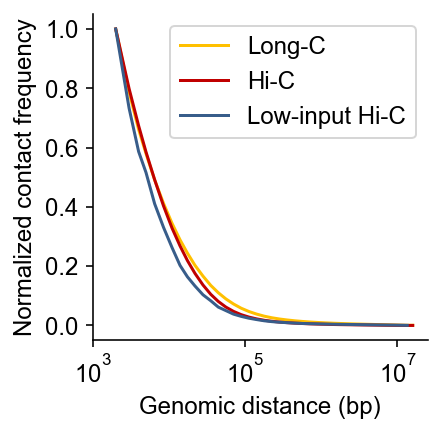

In [19]:
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#FFC000','#C00000','#385D8A','#2BB7B3','#3C8C6F', '#385D8A', '#632523'])
mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/table_for_distance_10.1.csv'
out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/Distance_three_method_new.png'
mcool_draw(mcool_hicVSdivideorder,16,'process',out_hicVSdivideorder)

# col_CEN

In [ ]:
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#2BB7B3','#3C8C6F','#385D8A','#632523','#C00000','#ED6D00','#FFC000'])
mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/mcool_table_hicVSdivideorder_new.csv'
out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/Distance_hicVSdivideorder_new.png'
mcool_draw(mcool_hicVSdivideorder, 16,'process', out_hicVSdivideorder)

In [11]:
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#FFC000','#C00000','#385D8A','#2BB7B3','#3C8C6F', '#385D8A', '#632523'])
nolowhic_mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/no_low.csv'
out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/nolowhic_Distance_three_method_new.png'
mcool_draw(nolowhic_mcool_hicVSdivideorder,16,'process',out_hicVSdivideorder)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/public/home/lizw/task/pore_c/DpnII_hic2/4DN_cool/MAPQ_1_1000.mcool', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [13]:
nolowhic_mcool_hicVSdivideorder

'/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/no_low.csv'

In [ ]:
#all_nolow_vshic
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#FFC000','#C00000','#385D8A','#2BB7B3','#3C8C6F', '#385D8A', '#632523'])
nolowhic_mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/no_low.csv'
nolowhic_out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/nolowhic_Distance_three_method_new.png'
mcool_draw(nolowhic_mcool_hicVSdivideorder,16,'process',nolowhic_out_hicVSdivideorder)

In [ ]:
#DJ_nolow_vshic
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#FFC000','#C00000','#385D8A','#2BB7B3','#3C8C6F', '#385D8A', '#632523'])
DJ_mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/DJ_no_low.csv'
DJ_out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/DJ_Distance_three_method_new.png'
mcool_draw(DJ_mcool_hicVSdivideorder,16,'process',DJ_out_hicVSdivideorder)

In [ ]:
#DJ_nolow_divide_order 
mpl.rcParams['axes.prop_cycle'] = cycler('color',['#FFC000','#C00000','#385D8A','#2BB7B3','#3C8C6F', '#385D8A', '#632523'])
DJ_divide_mcool_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/DJ_divideorder.csv'
DJ_divide_out_hicVSdivideorder = '/public/home/lizw/task/pore_c/porec_1000_filter_mainchr_result/distance_order/DJ_divide_Distance_three_method_new.png'
mcool_draw(DJ_divide_mcool_hicVSdivideorder,16,'process',DJ_divide_out_hicVSdivideorder)